In [4]:
%pip install --upgrade pip
%pip install --upgrade transformers
%pip install --upgrade torch
%pip install --upgrade pandas
# %pip uninstall TensorFlow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Data Processing

In [94]:
import pandas as pd
import re
pd.set_option('display.max_colwidth',0)

In [95]:
#pd.set_option('display.max_rows', None)
df = pd.read_csv('binary_labelled_terms.csv')
df = df.drop(['Topic','Term Percentage','Term Frequency','First PMID','List of all sentences for term','List of PMIDs'], axis=1)
df = df.rename(columns={'First Sentence': 'first_sentence'})
df['Term-Label'] = df['Term-Label'].replace("general_term","noise")
def clean_text(text):
    # Remove non-breaking spaces (replace '\xa0' with a regular space)
    cleaned_text = text.replace('</i>', ' ')
    cleaned_text = cleaned_text.replace('<i>', ' ')
    # Remove extra whitespace and trim the text
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text
# Apply the clean_text function to your DataFrame
df['first_sentence'] = df['first_sentence'].apply(clean_text)
df = df[['Term','first_sentence','Term-Label']]
# Print the cleaned DataFrame
df.head(5)

,Term,first_sentence,Term-Label
0,pcos,Polycystic ovary syndrome (PCOS) is a gynecological endocrine disorder and the leading cause of anovulatory female infertility.,medical_term
1,infertility,The following describers were used: chlamydia trachomatis AND infertility ; chlamydia trachomatis AND tubal alteration AND infertility ; chlamydia AND low pregnancy rates .,medical_term
2,women,"In the last 20 years, aspecific auto-immunity, defined as positivity of auto-antibodies in blood sample without clinical or biological criteria for defined diseases, has been evoked in a subpopulation of infertile women.",noise
3,sperm,"Clinical management for unexplained infertility includes expectant management as well as active treatments, including ovarian stimulation (OS), intrauterine insemination (IUI), OS-IUI, and in vitro fertilisation (IVF) with or without intracytoplasmic sperm injection (ICSI).Existing systematic reviews have conducted head-to-head comparisons of these interventions using pairwise meta-analyses.",medical_term
4,review,"Hence, the goal of the present review is to contribute to a better elucidation of this matter.",medical_term


In [96]:
""" df = pd.read_csv('labelled_terms.csv')
df = df.drop(['Topic','Term Percentage'], axis=1)
df['Term-Label'] = df['Term-Label'].replace("general_term","noise")
def clean_text(text):
    # Remove special characters, punctuation, and extra whitespace
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Remove non-breaking spaces (replace '\xa0' with a regular space)
    cleaned_text = cleaned_text.replace('\xa0', ' ')
    cleaned_text = cleaned_text.replace('xa0', ' ')
    # Remove extra whitespace and trim the text
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text
# Apply the clean_text function to your DataFrame
df['first_sentence'] = df['first_sentence'].apply(clean_text)
# Print the cleaned DataFrame
df.head(5) """

' df = pd.read_csv(\'labelled_terms.csv\')\ndf = df.drop([\'Topic\',\'Term Percentage\'], axis=1)\ndf[\'Term-Label\'] = df[\'Term-Label\'].replace("general_term","noise")\ndef clean_text(text):\n    # Remove special characters, punctuation, and extra whitespace\n    cleaned_text = re.sub(r\'[^a-zA-Z0-9\\s]\', \' \', text)\n    # Remove non-breaking spaces (replace \'\xa0\' with a regular space)\n    cleaned_text = cleaned_text.replace(\'\xa0\', \' \')\n    cleaned_text = cleaned_text.replace(\'xa0\', \' \')\n    # Remove extra whitespace and trim the text\n    cleaned_text = \' \'.join(cleaned_text.split())\n    return cleaned_text\n# Apply the clean_text function to your DataFrame\ndf[\'first_sentence\'] = df[\'first_sentence\'].apply(clean_text)\n# Print the cleaned DataFrame\ndf.head(5) '

Some models 

In [173]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import seaborn as sns
import matplotlib.pyplot as plt

In [211]:
def test_single_model(model_name, df):
    print(f"Testing model: {model_name}")
    df_tested = tokenModelAndPipe(model_name, df)
    label = get_entity_name(df_tested)
    if label != "No valid entity_group found for medical_term.":
        # 创建一个单独的图表来显示混淆矩阵和性能指标
        fig, ax = plt.subplots(figsize=(6, 6))
        precision, recall, f1 = get_score_print(df_tested, label, ax, model_name)

        # 显示图表
        plt.tight_layout()
        plt.show()
    else:
        print(label)
def test_multiple_models(model_list, df):
    num_models = len(model_list)
    num_rows = num_cols = int(num_models**0.5)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    fig.suptitle('Confusion Matrices for Different Models')
    f1_scores = {}  # 用于存储每个模型的F1分数

    for i, model_name in enumerate(model_list):
        ax = axes[i // num_cols, i % num_cols]
        df_tested = tokenModelAndPipe(model_name, df.copy())
        label = get_entity_name(df_tested)
        precision, recall, f1 = get_score_print(df_tested, label, ax, model_name)
        f1_scores[model_name] = f1
        plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    # 绘制F1分数的直方图
    plt.figure(figsize=(10, 5))
    bars = plt.barh(list(f1_scores.keys()), list(f1_scores.values()), color='blue')  # 注意使用barh来绘制水平条形图
    # 在每个条形图末端添加文本标签
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                 f'{bar.get_width():.2f}', 
                 va='center')
    plt.ylabel('Model Name')  # 纵坐标为模型名称
    plt.xlabel('F1 Score')  # 横坐标为F1分数
    plt.title('F1 Scores for Different Models')
    plt.show()
def tokenModelAndPipe(model_name, df):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
    df_copy = df.copy()
    df_copy['ner_results'] = df_copy['first_sentence'].apply(lambda sentence: pipe(sentence))
    df_copy['entity_group'] = df_copy.apply(find_entity_group, axis=1)
    return df_copy
def find_entity_group(row):
    input_string = row['ner_results']
    word_to_check = row['Term']
    for item in input_string:
        words = item.get('word', '').split()
        word_count = len(words)
        if word_to_check in words and word_count <= 3:
            return item.get('entity_group')
    return None
def get_entity_name(df):
    words = [word for word in df[df['Term-Label'] == 'medical_term']['entity_group'] if word is not None]
    if len(words) > 0:
        most_common_word = max(set(words), key=words.count)
        unique_original_words = set(words)
        modifications = {original_word: most_common_word for original_word in unique_original_words if original_word != most_common_word}
        condition = (df['Term-Label'] == 'medical_term') & (df['entity_group'].notnull())
        df.loc[condition, 'entity_group'] = most_common_word
        for original, new in modifications.items():
            print(f'"{original}" -> "{new}"')
        result = most_common_word
    else:
        result = "No valid entity_group found for medical_term."
    return result
def get_score_print(df, medical_label, ax, model_name):
    TP = len(df[(df['Term-Label'] == 'medical_term') & (df['entity_group'] == medical_label)])
    FP = len(df[(df['Term-Label'] == 'medical_term') & (df['entity_group'] != medical_label)])
    FN = len(df[(df['Term-Label'] != 'medical_term') & (df['entity_group'] == medical_label)])
    TN = len(df[(df['Term-Label'] != 'medical_term') & (df['entity_group'] != medical_label)])
    confusion_matrix = [
        [TN, FN], 
        [FP, TP]
        ]
    labels = ['noise','medical_term']

    Precision = TP / (TP + FP) if TP + FP > 0 else 0
    Recall = TP / (TP + FN) if TP + FN > 0 else 0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if Precision + Recall > 0 else 0

    # 定义性能信息字符串
    performance_info = f'Precision: {Precision:.2f}, Recall: {Recall:.2f}, F1: {F1:.2f}'

    # 在指定的轴上绘制混淆矩阵
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'Model: {model_name}\n{performance_info}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')

    print(f"Precision: {Precision}")
    print(f"Recall: {Recall}")
    print(f"F1 Score: {F1}")

    return Precision, Recall, F1

Quick Through

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Precision: 0.14705882352941177
Recall: 0.9090909090909091
F1 Score: 0.25316455696202533
"treatment" -> "problem"
"test" -> "problem"
Precision: 0.5147058823529411
Recall: 0.9722222222222222
F1 Score: 0.6730769230769229


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


"I" -> "B"
Precision: 0.17647058823529413
Recall: 0.9230769230769231
F1 Score: 0.29629629629629634
"treatment" -> "problem"
"test" -> "problem"
Precision: 0.5147058823529411
Recall: 0.9722222222222222
F1 Score: 0.6730769230769229
"B_problem" -> "I_problem"
"B_treatment" -> "I_problem"
"B_test" -> "I_problem"
"I_test" -> "I_problem"
"I_treatment" -> "I_problem"
"B_person" -> "I_problem"
Precision: 0.27941176470588236
Recall: 1.0
F1 Score: 0.4367816091954023


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


"Intervention" -> "Outcome"
Precision: 0.058823529411764705
Recall: 1.0
F1 Score: 0.1111111111111111
"B_problem" -> "I_problem"
"B_treatment" -> "I_problem"
"B_test" -> "I_problem"
"I_test" -> "I_problem"
"I_treatment" -> "I_problem"
Precision: 0.39705882352941174
Recall: 1.0
F1 Score: 0.5684210526315789
Precision: 0.1323529411764706
Recall: 0.9
F1 Score: 0.23076923076923075
"Medication" -> "Health_Problem"
"Medical_History" -> "Health_Problem"
"Procedure_Name" -> "Health_Problem"
Precision: 0.25
Recall: 1.0
F1 Score: 0.4


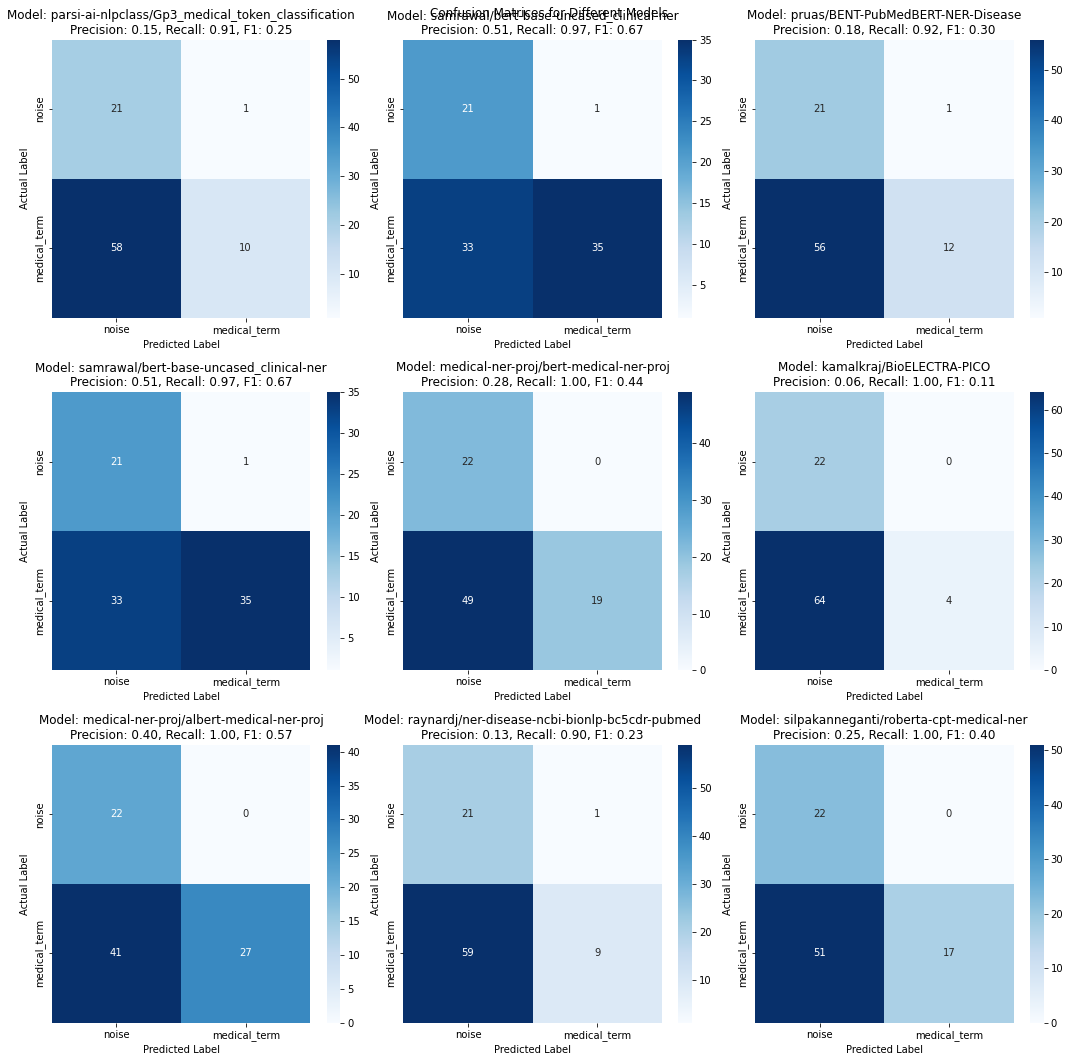

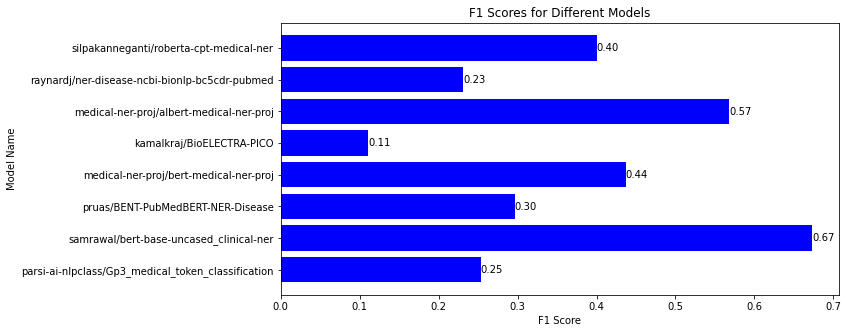

In [220]:
bio_model_list = [
    'alvaroalon2/biobert_diseases_ner',
    'ugaray96/biobert_ncbi_disease_ner',
    'raynardj/ner-disease-ncbi-bionlp-bc5cdr-pubmed',
    'kamalkraj/BioELECTRA-PICO',
    'drAbreu/bioBERT-NER-NCBI_disease',
    'sschet/biobert_chemical_ner',
    'drAbreu/bioBERT-NER-BC2GM_corpus',
    'Dr-BERT/CAS-Biomedical-POS-Tagging',
    'commanderstrife/PV-Bio_clinicalBERT-superset',
    'fidukm34/biobert_v1.1_pubmed-finetuned-ner-finetuned-ner',
    'mrm8488/biomedtra-small-finenuned-clinical-ner',
    'jordyvl/biobert-base-cased-v1.2_ncbi_disease-sm-first-ner',
    'rjac/biobert-ner-diseases-model',
    'chintagunta85/biobert-base-cased-v1.2-bc2gm-ner',
    'pruas/BENT-PubMedBERT-NER-Bioprocess',
    'sschet/biomedical-ner-all',
    'sschet/biobert_genetic_ner',
]#17
pubmed_model_list = [
    'pruas/BENT-PubMedBERT-NER-Disease',
    'fidukm34/biobert_v1.1_pubmed-finetuned-ner-finetuned-ner',
    'rebeccakoganlee/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext-finetuned-ner'
]
model_list = bio_model_list + pubmed_model_list
model_results = test_multiple_models(model_list, df)

BERT

Testing model: parsi-ai-nlpclass/Gp3_medical_token_classification


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Precision: 0.14705882352941177
Recall: 0.9090909090909091
F1 Score: 0.25316455696202533


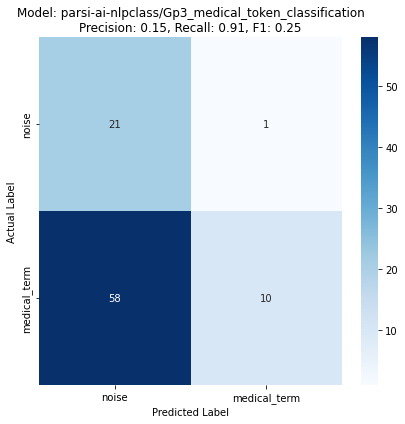

In [213]:
test_single_model("parsi-ai-nlpclass/Gp3_medical_token_classification", df)

Testing model: samrawal/bert-base-uncased_clinical-ner
"treatment" -> "problem"
"test" -> "problem"
Precision: 0.5147058823529411
Recall: 0.9722222222222222
F1 Score: 0.6730769230769229


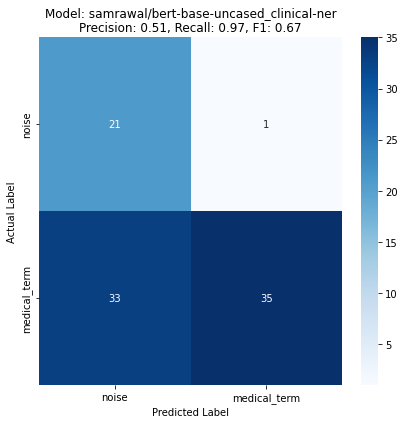

In [212]:
test_single_model("samrawal/bert-base-uncased_clinical-ner",df)

Testing model: pruas/BENT-PubMedBERT-NER-Disease


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


"I" -> "B"
Precision: 0.17647058823529413
Recall: 0.9230769230769231
F1 Score: 0.29629629629629634


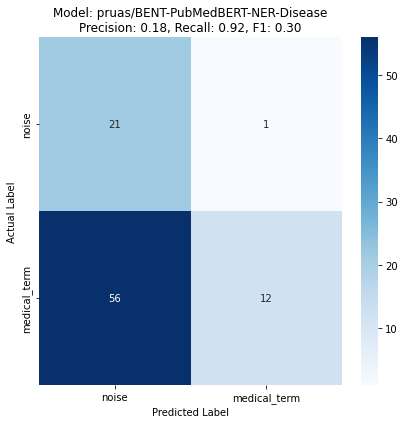

In [214]:
test_single_model("pruas/BENT-PubMedBERT-NER-Disease",df)

Testing model: medical-ner-proj/bert-medical-ner-proj
"B_problem" -> "I_problem"
"B_treatment" -> "I_problem"
"B_test" -> "I_problem"
"I_test" -> "I_problem"
"I_treatment" -> "I_problem"
"B_person" -> "I_problem"
Precision: 0.27941176470588236
Recall: 1.0
F1 Score: 0.4367816091954023


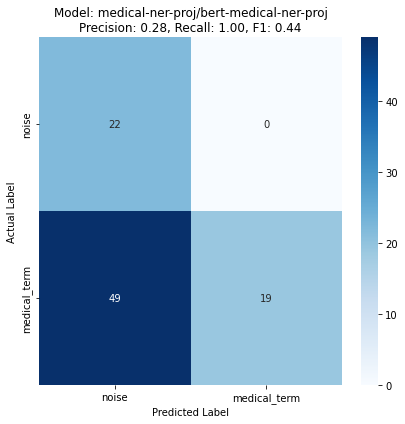

In [215]:
test_single_model("medical-ner-proj/bert-medical-ner-proj",df)
#df['entity_group'] = df['entity_group'].replace("B_person", None)

ELECTRA

Testing model: kamalkraj/BioELECTRA-PICO


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


"Intervention" -> "Outcome"
Precision: 0.058823529411764705
Recall: 1.0
F1 Score: 0.1111111111111111


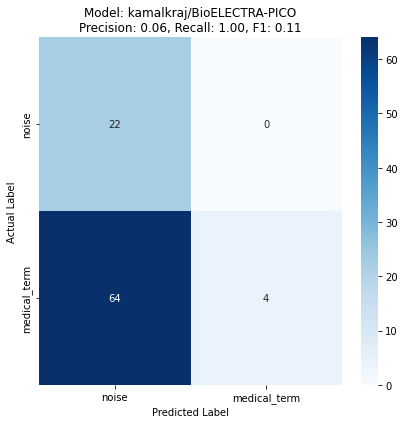

In [216]:
test_single_model("kamalkraj/BioELECTRA-PICO",df)

ALBERT

Testing model: medical-ner-proj/albert-medical-ner-proj
"B_problem" -> "I_problem"
"B_treatment" -> "I_problem"
"B_test" -> "I_problem"
"I_test" -> "I_problem"
"I_treatment" -> "I_problem"
Precision: 0.39705882352941174
Recall: 1.0
F1 Score: 0.5684210526315789


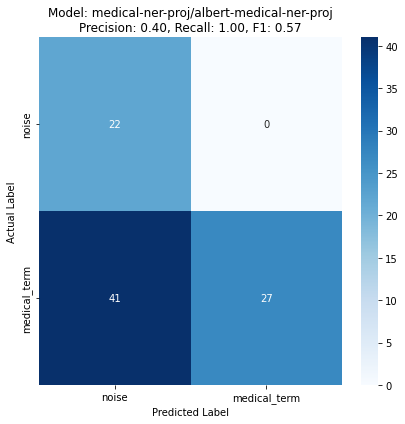

In [217]:
test_single_model("medical-ner-proj/albert-medical-ner-proj",df)

roBERTa

Testing model: silpakanneganti/roberta-cpt-medical-ner
"Medication" -> "Health_Problem"
"Medical_History" -> "Health_Problem"
"Procedure_Name" -> "Health_Problem"
Precision: 0.25
Recall: 1.0
F1 Score: 0.4


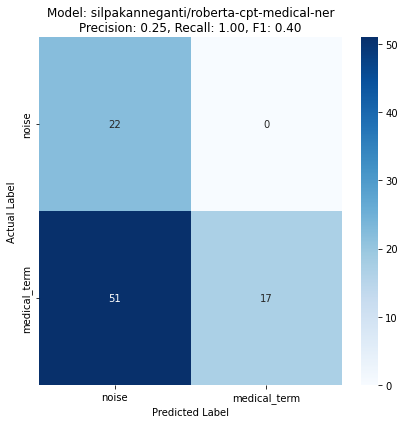

In [218]:
test_single_model("silpakanneganti/roberta-cpt-medical-ner",df)

Testing model: raynardj/ner-disease-ncbi-bionlp-bc5cdr-pubmed
Precision: 0.1323529411764706
Recall: 0.9
F1 Score: 0.23076923076923075


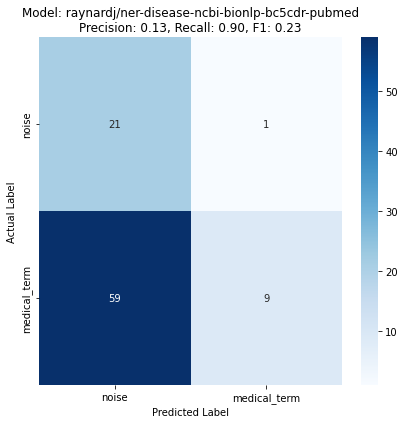

In [219]:
test_single_model("raynardj/ner-disease-ncbi-bionlp-bc5cdr-pubmed",df)